載入套件

In [271]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cbook import boxplot_stats
from scipy.stats import binom
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

載入資料集

In [272]:
df = pd.read_csv('analysis.csv')
df.head()

,Item_No,Length,Width,Height,Operator
0,1,102.67,49.53,19.69,Op-1
1,2,102.50,51.42,19.63,Op-1
2,3,95.37,52.25,21.51,Op-1
3,4,94.77,49.24,18.60,Op-1
4,5,104.26,47.90,19.46,Op-1


In [273]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Item_No   500 non-null    int64  
 1   Length    500 non-null    float64
 2   Width     500 non-null    float64
 3   Height    500 non-null    float64
 4   Operator  500 non-null    object 
dtypes: float64(3), int64(1), object(1)
memory usage: 19.7+ KB


In [274]:
df.describe()

,Item_No,Length,Width,Height
count,500.000000,500.000000,500.00000,500.000000
mean,250.500000,99.769140,49.93288,20.293220
std,144.481833,4.107471,2.11382,1.051718
min,1.000000,87.520000,42.74000,17.370000
25%,125.750000,96.835000,48.34000,19.475000
50%,250.500000,99.565000,49.82500,20.310000
75%,375.250000,102.035000,51.46250,21.142500
max,500.000000,116.600000,58.26000,23.390000


In [275]:
df = df.drop('Item_No', axis=1)

探索性資料分析

<AxesSubplot:xlabel='Operator', ylabel='count'>

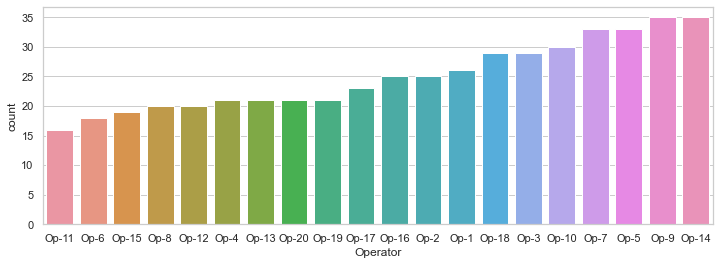

In [276]:
plt.figure(figsize=(12,4))
sns.set_theme(style="whitegrid")
sns.countplot(data=df, x='Operator', order=df['Operator'].value_counts().index[::-1])

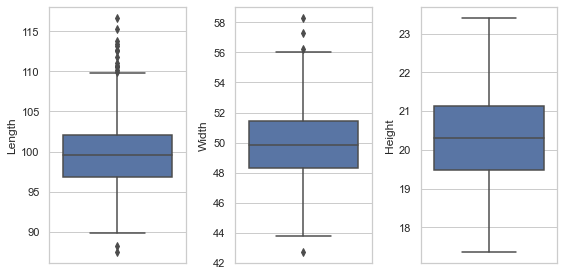

In [277]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8,4))
sns.boxplot(data=df, y=df['Length'], ax=axes[0])
sns.boxplot(data=df, y=df['Width'], ax=axes[1])
sns.boxplot(data=df, y=df['Height'], ax=axes[2])
fig.tight_layout()

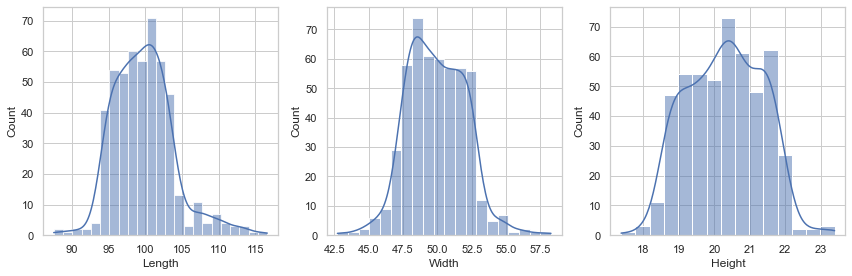

In [278]:
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
sns.histplot(data=df, x=df['Length'], kde=True, ax=axes[0])
sns.histplot(data=df, x=df['Width'], kde=True, ax=axes[1])
sns.histplot(data=df, x=df['Height'], kde=True, ax=axes[2])
fig.tight_layout()

將盒鬚圖中的異常值設為“有缺陷的”
下鬚線位於Q1 - whis x (Q3-Q1)之上的最低基準，而上鬚線位於 Q3 + whis x (Q3-Q1) 之下的最高基準處。

In [279]:
feat = ['Length','Width','Height']

In [280]:
for col in feat:
    print(col)
    print(pd.Series(boxplot_stats(df[col])[0]))
    print('\n')

Length
mean                                               99.76914
iqr                                                     5.2
cilo                                              99.199895
cihi                                              99.930105
whishi                                               109.79
whislo                                                89.82
fliers    [87.52, 88.28, 110.54, 110.18, 110.72, 112.69,...
q1                                                   96.835
med                                                  99.565
q3                                                  102.035
dtype: object


Width
mean                          49.93288
iqr                             3.1225
cilo                         49.605761
cihi                         50.044239
whishi                           56.04
whislo                            43.8
fliers    [42.74, 57.26, 58.26, 56.26]
q1                               48.34
med                             49.825
q3                  

In [281]:
#從探索性資料分析的結果判別出不良品並標籤化
def get_status(row):
    for col in feat:
        if (
            (row[col] > boxplot_stats(df[col])[0]['whishi']) 
            or 
            (row[col] < boxplot_stats(df[col])[0]['whislo'])
        ):
            return 'Defective'
    return 'Perfect'
df['Status'] = df.apply(get_status,axis=1)
df[df['Status']=='Defective']

,Length,Width,Height,Operator,Status
41,110.54,51.07,21.95,Op-2,Defective
56,110.18,51.89,21.36,Op-3,Defective
61,105.00,57.26,21.62,Op-3,Defective
63,110.72,52.54,21.06,Op-3,Defective
67,112.69,50.68,20.33,Op-3,Defective
68,111.83,53.31,20.12,Op-3,Defective
69,103.73,58.26,20.37,Op-3,Defective
71,109.87,52.23,20.94,Op-3,Defective
73,113.45,46.96,23.31,Op-3,Defective
85,104.22,42.74,19.05,Op-4,Defective


In [282]:
df['Status'].value_counts()

Perfect      480
Defective     20
Name: Status, dtype: int64

<AxesSubplot:xlabel='Status', ylabel='count'>

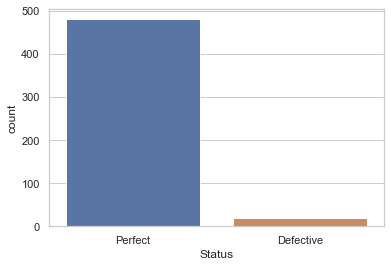

In [283]:
sns.countplot(data=df, x='Status')

In [284]:
defective = 100*df[df['Status'] == 'Defective']['Status'].count() / df['Status'].count()
perfect = 100*df[df['Status'] == 'Perfect']['Status'].count() / df['Status'].count()
print(f'不良率: {defective}%')
print(f'良率:  {perfect}%')

不良率: 4.0%
良率:  96.0%


<AxesSubplot:xlabel='Status', ylabel='count'>

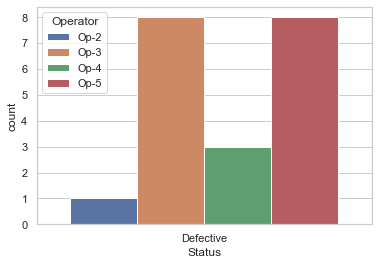

In [285]:
#觀察產生不良率的作業員生產數量
defective = df[df['Status'] == 'Defective']['Status']
hue_op = df[df['Status'] == 'Defective']['Operator']
sns.countplot(data=df, x=defective, hue=hue_op)

可得出產品不良的出處在以上人員:Op-2, Op-3, Op-4 and Op-5

In [286]:
defective_op = df[df['Status'] == 'Defective']['Operator'].unique()
defective_parts = df[df['Status'] == 'Defective']['Operator'].value_counts()
defective_total = df['Operator'].value_counts()
defective_comparision = (defective_parts/defective_total)[defective_op]

<AxesSubplot:ylabel='Operator'>

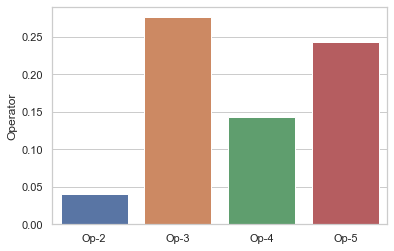

In [287]:
sns.barplot(x=defective_op, y=defective_comparision)

Op-5錯誤地製造了25%的零件Op-3的錯誤率也超過了 25%。
應考慮對這些操作員進行培訓。

<AxesSubplot:>

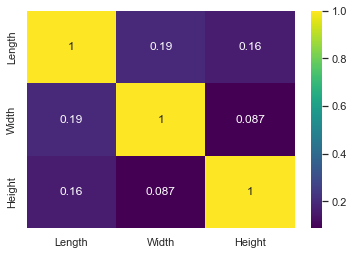

In [288]:
#原始數據的測量並不影響產品的相關性
sns.heatmap(df.corr(), annot=True, cmap='viridis')

In [289]:
meanL = df['Length'].mean() #99.76914
meanW = df['Width'].mean() #49.932880000000004
meanH = df['Height'].mean() #20.29322

生產中有 4% 的不良率，本研究假設決定隨機測試20個零件，若有 2 個或更少的不良品，將接受這批貨。

In [290]:
two_rejections = round(100 * binom.sf(2, 20, 0.04),2)
x_ax = np.arange(0, 21)
y_ax = binom.pmf(x_ax, 20, 0.04)
y_cumulative = binom.cdf(x_ax, 20, 0.04)

In [291]:
print(f'拒絕這批貨的機率: {two_rejections}%')

拒絕這批貨的機率: 4.39%


<AxesSubplot:>

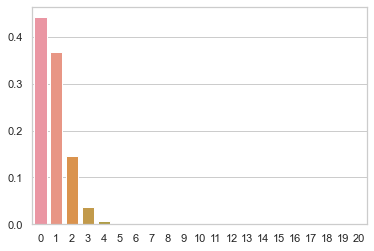

In [292]:
#每個樣本大約有45%的機率沒有不良品
#每個樣本大約有35%的機率只有1個不良品，
#每個樣本大約有15%的機率2個不良品
sns.barplot(x=x_ax, y=y_ax)

資料前處理

In [293]:
df.isnull().sum()

Length      0
Width       0
Height      0
Operator    0
Status      0
dtype: int64

In [294]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Length    500 non-null    float64
 1   Width     500 non-null    float64
 2   Height    500 non-null    float64
 3   Operator  500 non-null    object 
 4   Status    500 non-null    object 
dtypes: float64(3), object(2)
memory usage: 19.7+ KB


In [295]:
df = df.drop('Operator', axis=1)
categorical = ["Status"]

In [296]:
df_final = pd.get_dummies(df, columns=categorical, drop_first=True)

In [297]:
df_final

,Length,Width,Height,Status_Perfect
0,102.67,49.53,19.69,1
1,102.50,51.42,19.63,1
2,95.37,52.25,21.51,1
3,94.77,49.24,18.60,1
4,104.26,47.90,19.46,1
...,...,...,...,...
495,101.24,49.03,20.96,1
496,98.37,52.12,19.68,1
497,96.49,48.78,19.19,1
498,94.16,48.39,21.60,1


資料切割

In [298]:
X = df_final.drop('Status_Perfect', axis=1).values
y = df_final["Status_Perfect"].values

In [299]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

最大最小正規化

In [300]:
scaler = MinMaxScaler()

In [301]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

建立機器學習模型並進行模型績效評估

In [302]:
#決策樹
dt=DecisionTreeClassifier()
dt=dt.fit(X_train,y_train)
y_pred_dt=dt.predict(X_test)

In [303]:
print(classification_report(y_test,y_pred_dt,digits=4))
print(confusion_matrix(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0     1.0000    0.7000    0.8235        10
           1     0.9877    1.0000    0.9938       240

    accuracy                         0.9880       250
   macro avg     0.9938    0.8500    0.9087       250
weighted avg     0.9881    0.9880    0.9870       250

[[  7   3]
 [  0 240]]


In [304]:
#隨機森林
rf=RandomForestClassifier()
rf=rf.fit(X_train,y_train)
y_pred_rf=rf.predict(X_test)

In [305]:
print(classification_report(y_test,y_pred_rf,digits=4))
print(confusion_matrix(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0     1.0000    0.6000    0.7500        10
           1     0.9836    1.0000    0.9917       240

    accuracy                         0.9840       250
   macro avg     0.9918    0.8000    0.8709       250
weighted avg     0.9843    0.9840    0.9821       250

[[  6   4]
 [  0 240]]


In [306]:
#支持向量機
svc=SVC(probability=True)
svc=svc.fit(X_train,y_train)
y_pred_svc=svc.predict(X_test)

In [307]:
print(classification_report(y_test,y_pred_svc,digits=4))
print(confusion_matrix(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0     1.0000    0.4000    0.5714        10
           1     0.9756    1.0000    0.9877       240

    accuracy                         0.9760       250
   macro avg     0.9878    0.7000    0.7795       250
weighted avg     0.9766    0.9760    0.9710       250

[[  4   6]
 [  0 240]]


In [308]:
#極限梯度提升
xgb=XGBClassifier()
xgb=xgb.fit(X_train,y_train)
y_pred_xgb=xgb.predict(X_test)

[10:53:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [309]:
print(classification_report(y_test,y_pred_xgb,digits=4))
print(confusion_matrix(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0     0.8571    0.6000    0.7059        10
           1     0.9835    0.9958    0.9896       240

    accuracy                         0.9800       250
   macro avg     0.9203    0.7979    0.8478       250
weighted avg     0.9785    0.9800    0.9783       250

[[  6   4]
 [  1 239]]


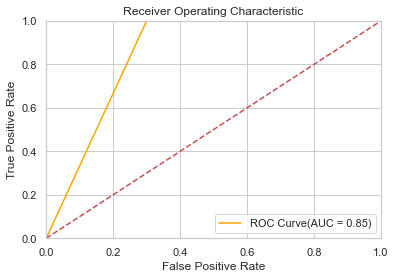

In [310]:
#繪製決策樹分類結果的作業特性曲線
from sklearn.metrics import roc_curve,auc
prob = dt.predict_proba(X_test)
prob = prob[:, 1]
fper, tper, thresholds = roc_curve(y_test, prob)
auc1=auc(fper,tper)
plt.title('Receiver Operating Characteristic')
plt.plot(fper, tper, color = 'orange', label = 'ROC Curve(AUC = %0.2f)' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

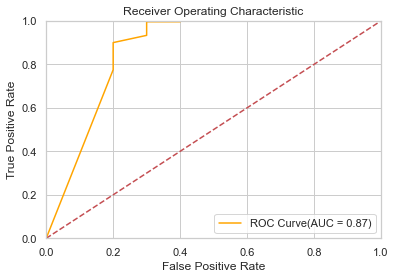

In [311]:
#繪製隨機森林分類結果的作業特性曲線
from sklearn.metrics import roc_curve,auc
prob = rf.predict_proba(X_test)
prob = prob[:, 1]
fper, tper, thresholds = roc_curve(y_test, prob)
auc1=auc(fper,tper)
plt.title('Receiver Operating Characteristic')
plt.plot(fper, tper, color = 'orange', label = 'ROC Curve(AUC = %0.2f)' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()  

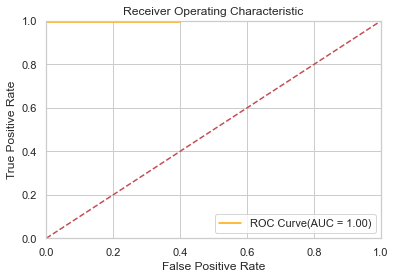

In [312]:
#繪製支持向量機結果的作業特性曲線
from sklearn.metrics import roc_curve,auc
prob = svc.predict_proba(X_test)
prob = prob[:, 1]
fper, tper, thresholds = roc_curve(y_test, prob)
auc1=auc(fper,tper)
plt.title('Receiver Operating Characteristic')
plt.plot(fper, tper, color = 'orange', label = 'ROC Curve(AUC = %0.2f)' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

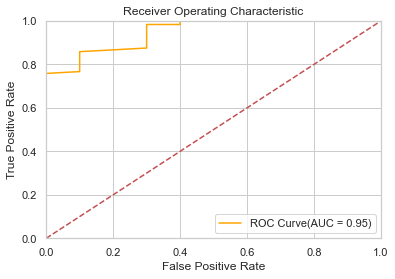

In [313]:
#繪製極限梯度提升分類結果的作業特性曲線
from sklearn.metrics import roc_curve,auc
prob = xgb.predict_proba(X_test)
prob = prob[:, 1]
fper, tper, thresholds = roc_curve(y_test, prob)
auc1=auc(fper,tper)
plt.title('Receiver Operating Characteristic')
plt.plot(fper, tper, color = 'orange', label = 'ROC Curve(AUC = %0.2f)' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [314]:
#繪製混淆矩陣
def plot_confusion_matrix(confusion_mat):
    plt.imshow(confusion_mat,interpolation='nearest',cmap=plt.cm.GnBu)
    plt.colorbar()
    for x in range(len(confusion_mat)):
        for y in range(len(confusion_mat)):
            plt.annotate(confusion_mat[x, y], xy=(x, y), horizontalalignment='center', verticalalignment='center')
    plt.title('Confusion Matrix')    
    plt.ylabel('True label')         
    plt.xlabel('Predicted label')     
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.show()

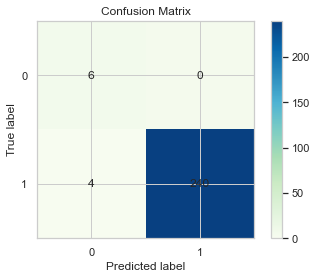

In [315]:
from sklearn import metrics
confusion_mat = metrics.confusion_matrix(y_test, y_pred_rf, labels=None, sample_weight=None)
plot_confusion_matrix(confusion_mat)